## Save best params from IBL global fits to initialize each animal's model

In [14]:
""" 
IMPORTS
"""
import json
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from post_processing_utils import load_glmhmm_data, load_cv_arr, \
    create_cv_frame_for_plotting, get_file_name_for_best_model_fold, \
    permute_transition_matrix, calculate_state_permutation

In [15]:
""" 
PARAMETERS
"""

# Parameters
C = 2  # number of output classes
num_folds = 5  # number of folds
D = 1  # number of output dimensions
K_max = 5  # maximum number of latent states
num_models = K_max + 2  # model for each latent + 2 lapse models
num_bins = 10
Ks = [2, 3]

In [16]:
"""
Useful directories
"""
data_dir = '../../data/ibl/data_for_cluster/'
results_dir = '../../results/ibl_global_fit/'
data_dir = '/home/ines/repositories/representation_learning_variability/DATA/GLMHMM/data_for_cluster/'
data_dir = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/GLMHMM/data_for_cluster/'
processed_ibl_data_path = data_dir + "data_by_bin" + str(num_bins) + "global_normalization/"



K = 2
[1 0]
K = 3
[0 2 1]
K = 2
[0 1]
K = 3
[2 0 1]
K = 2
[1 0]
K = 3
[0 1 2]


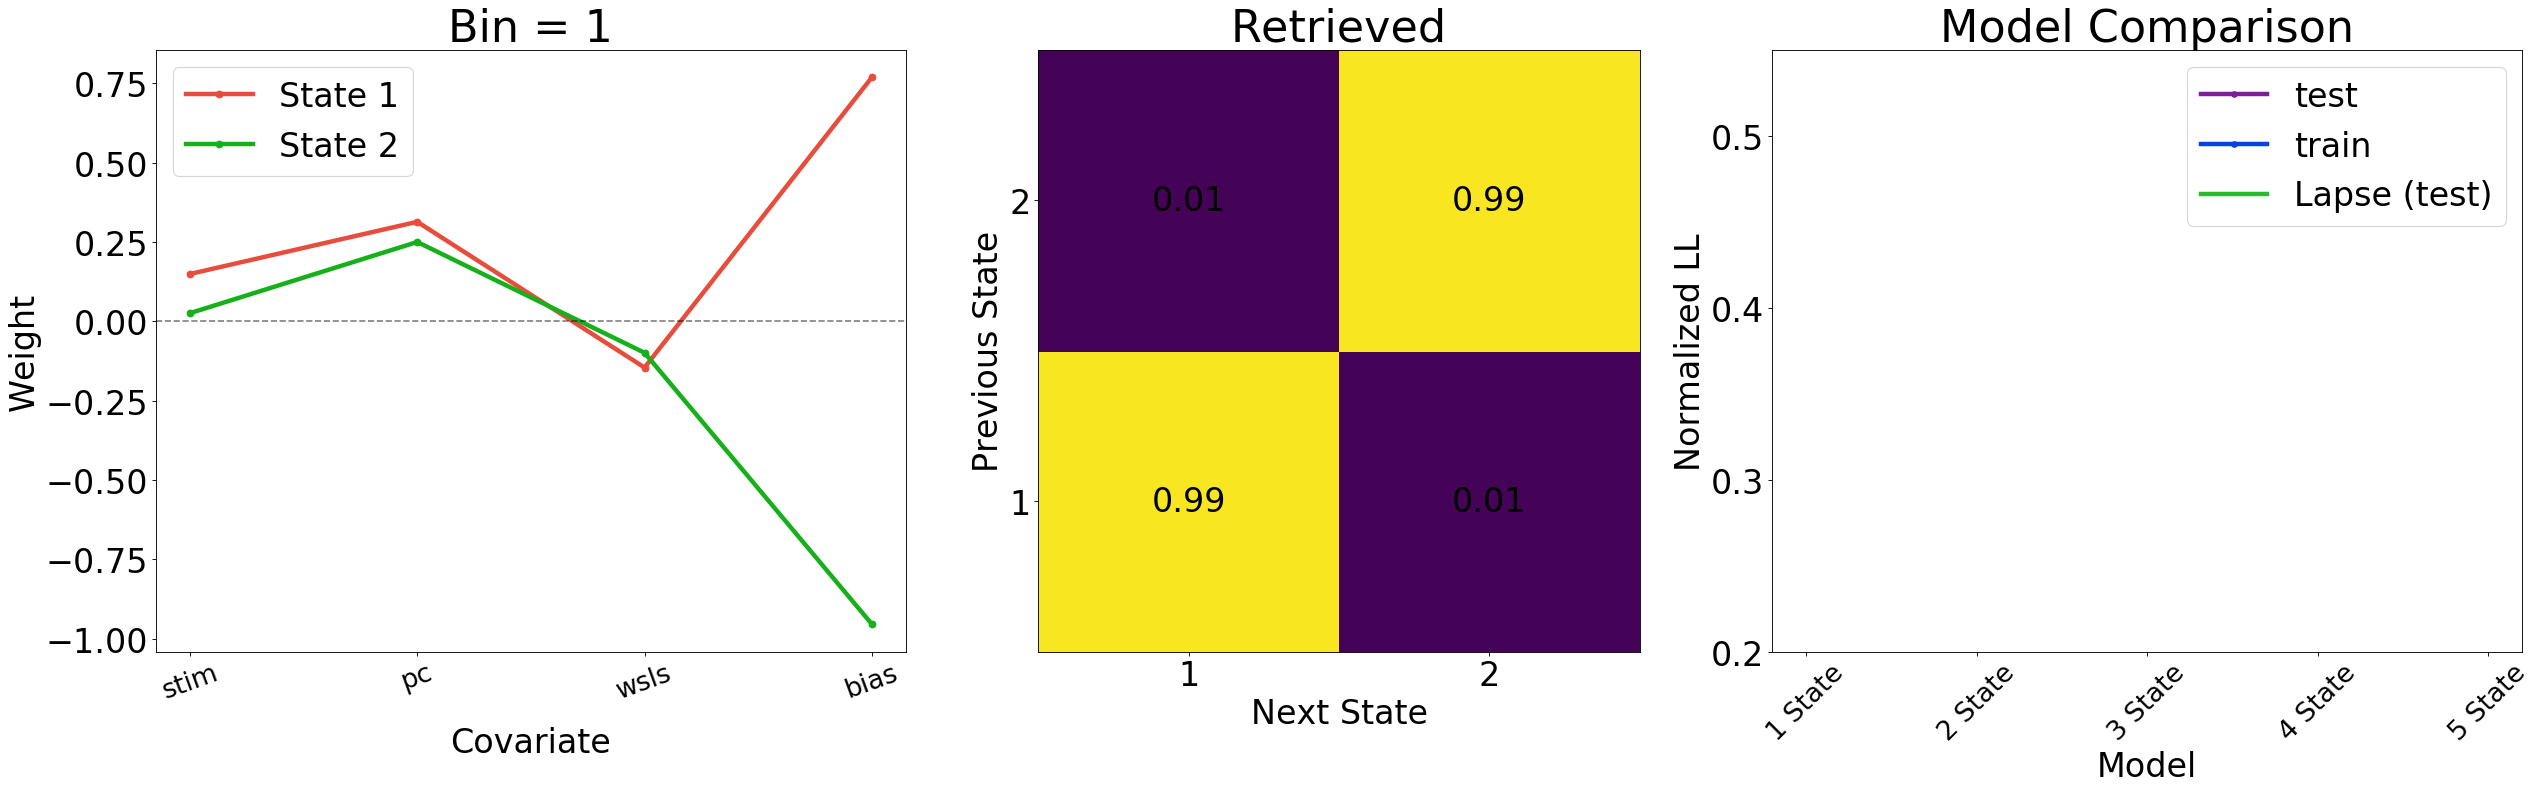

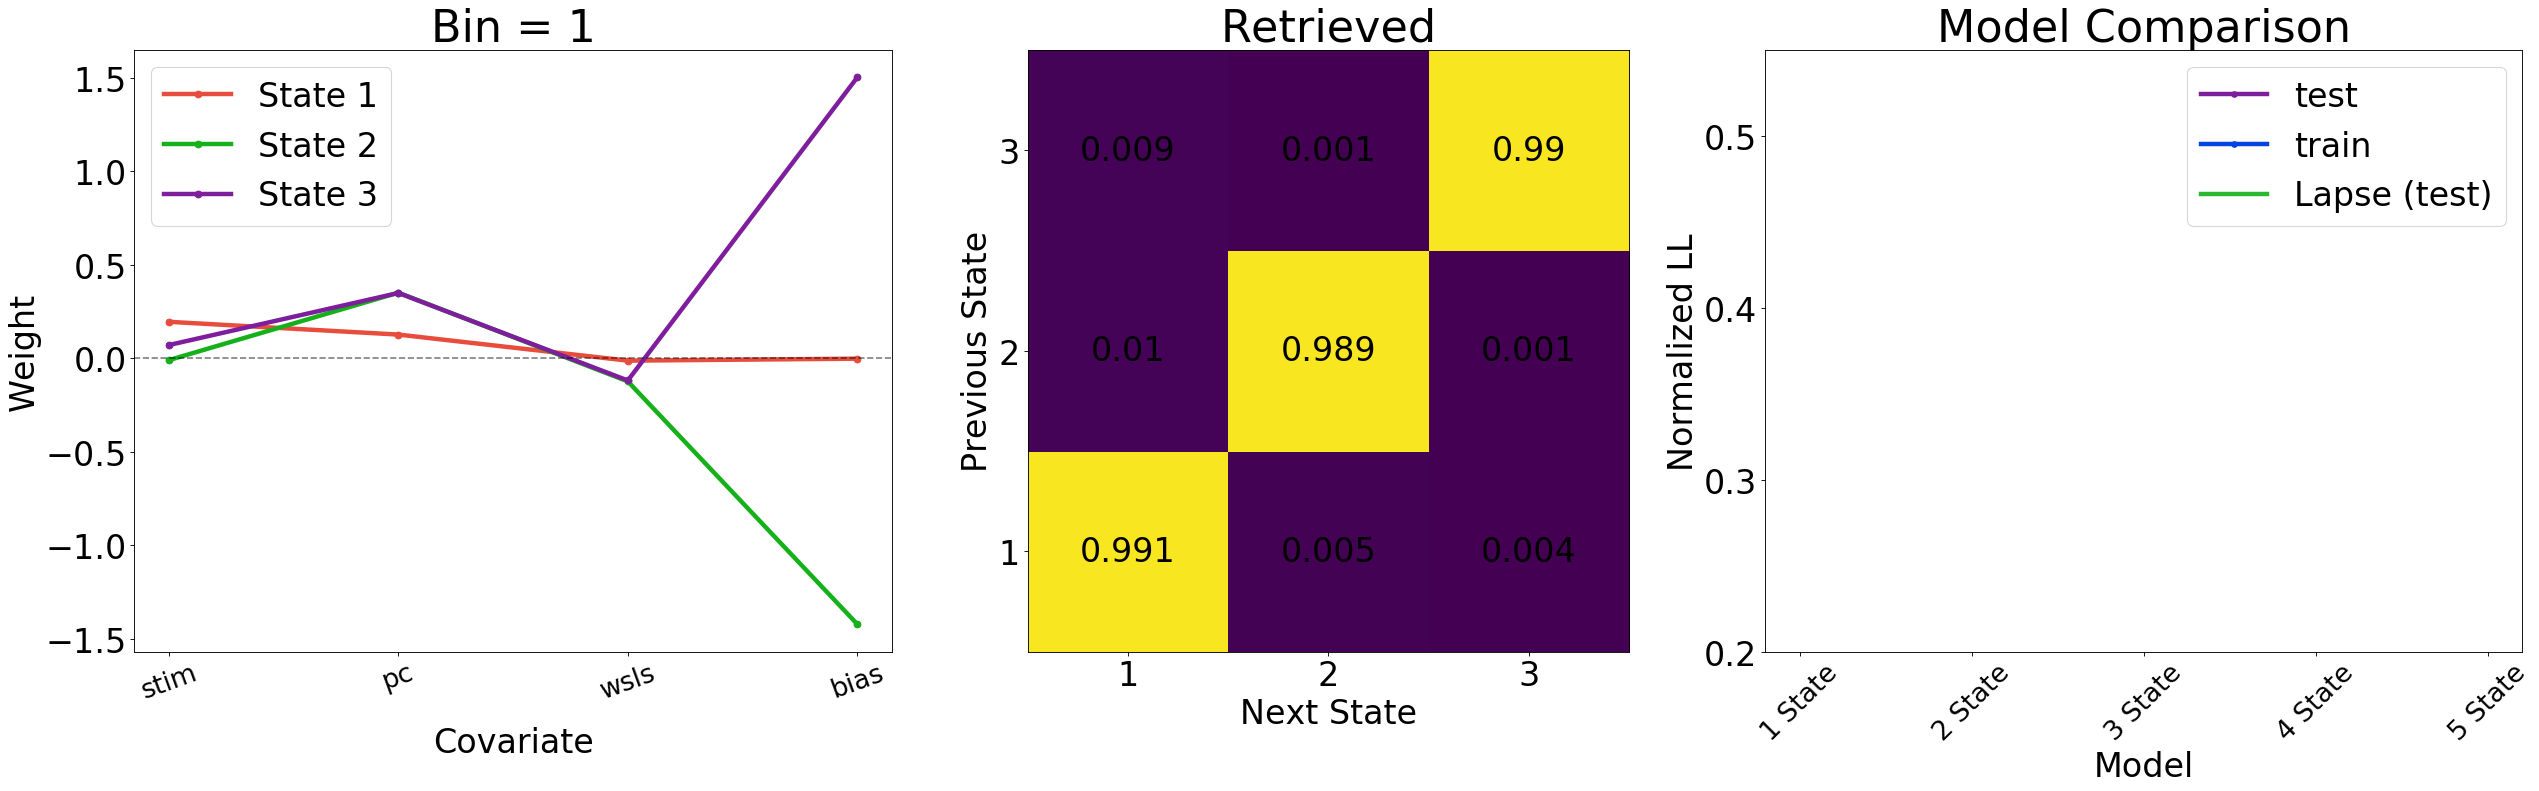

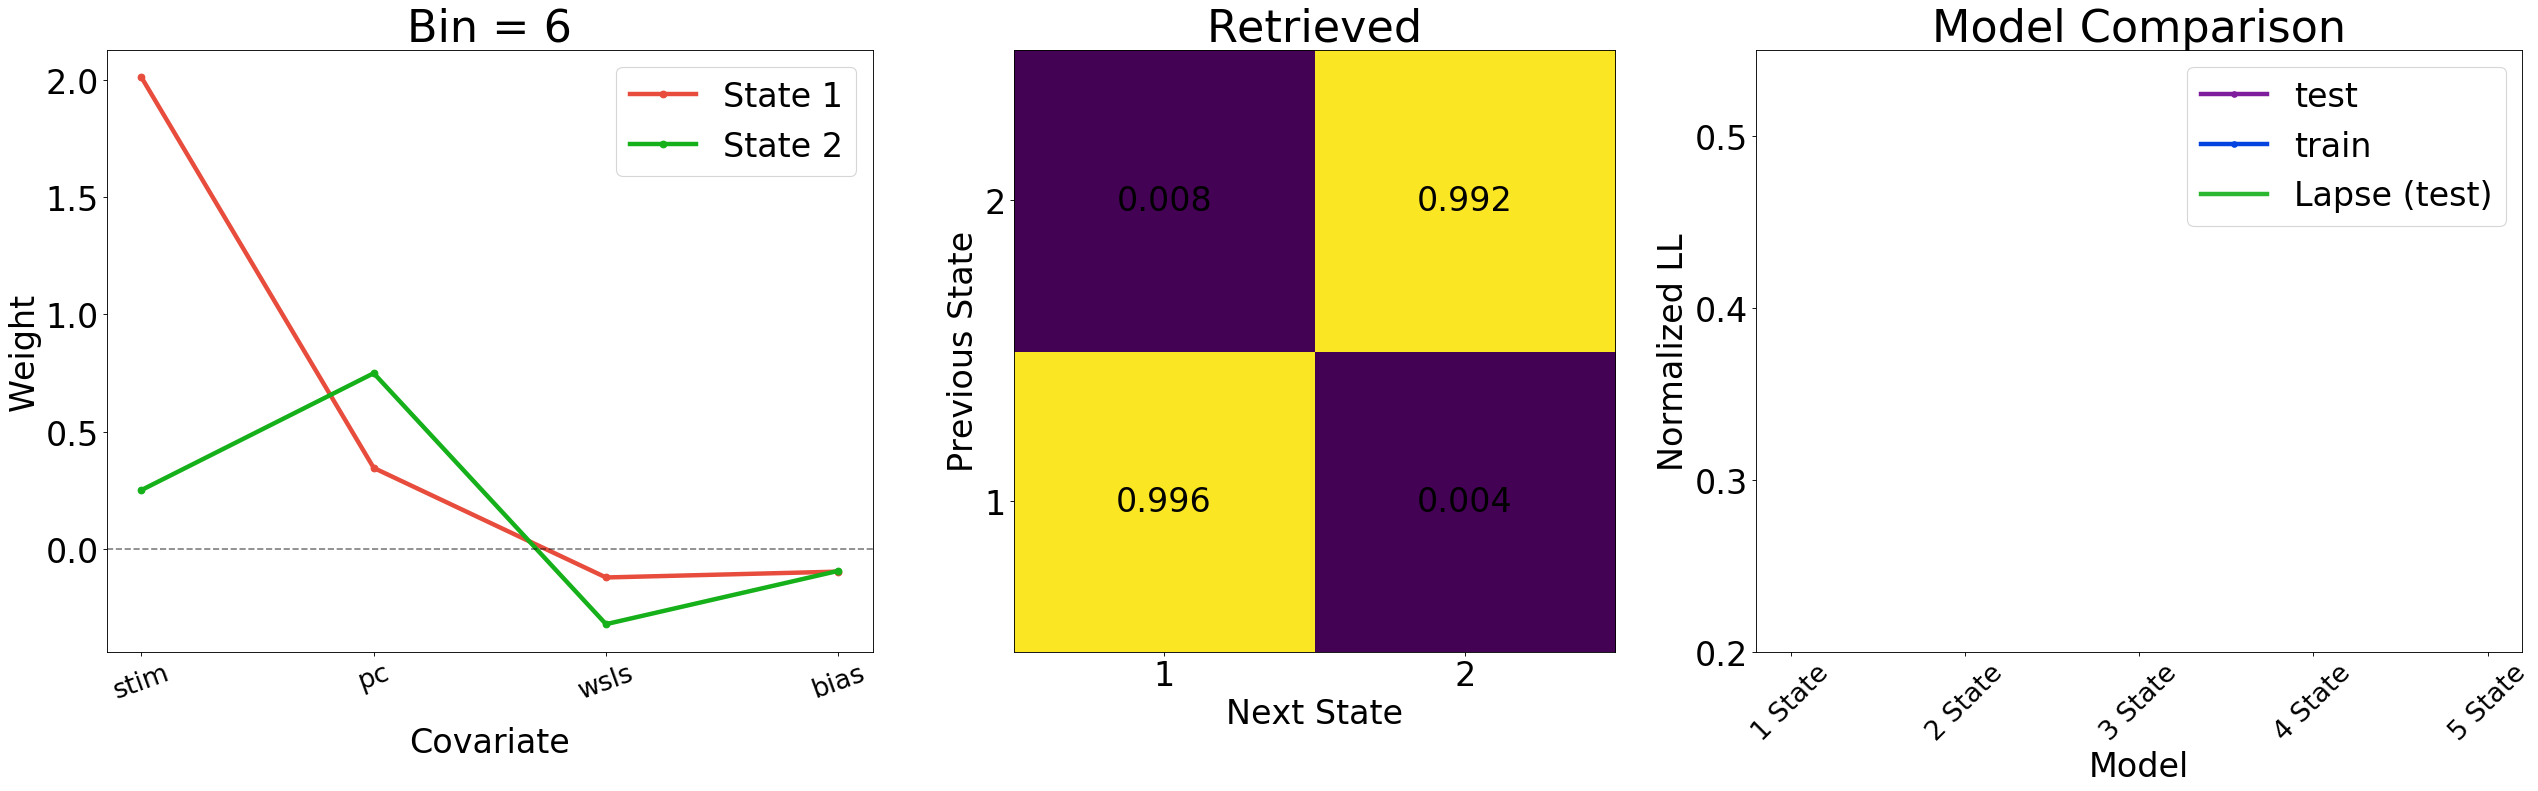

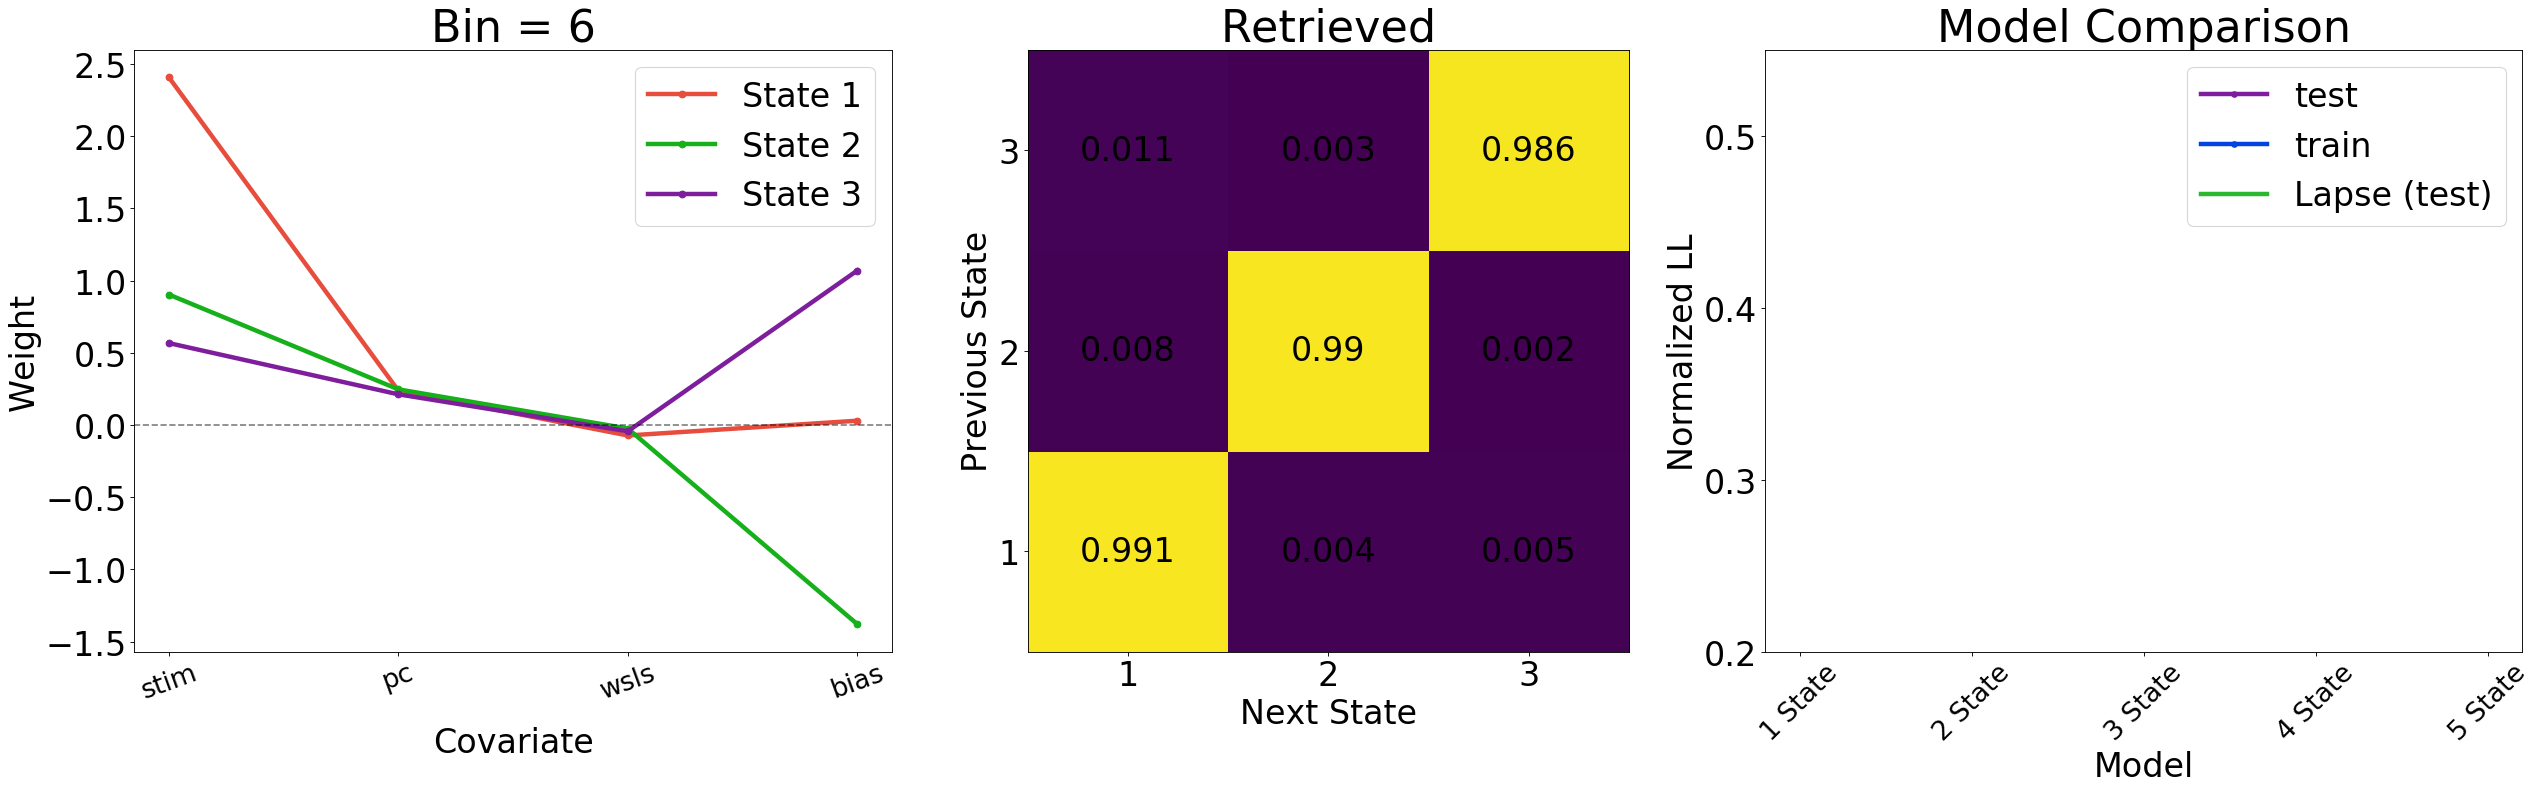

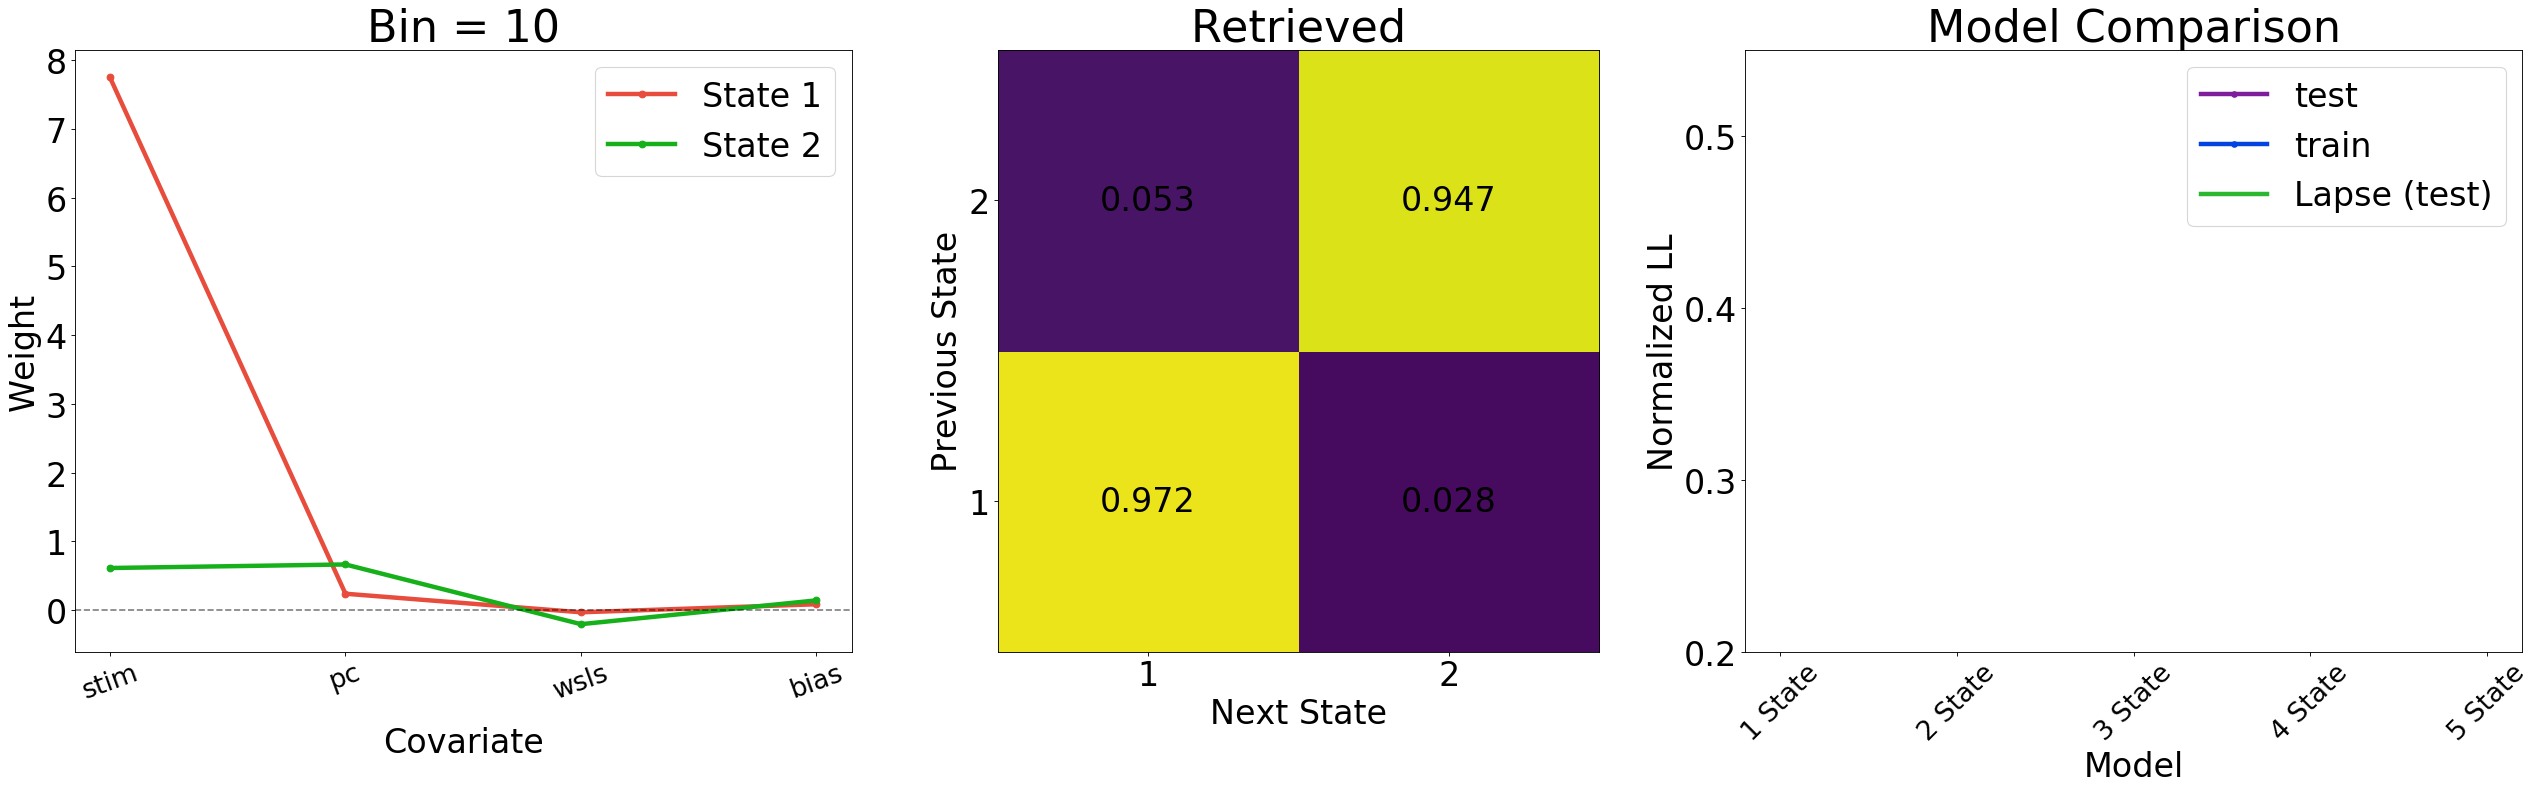

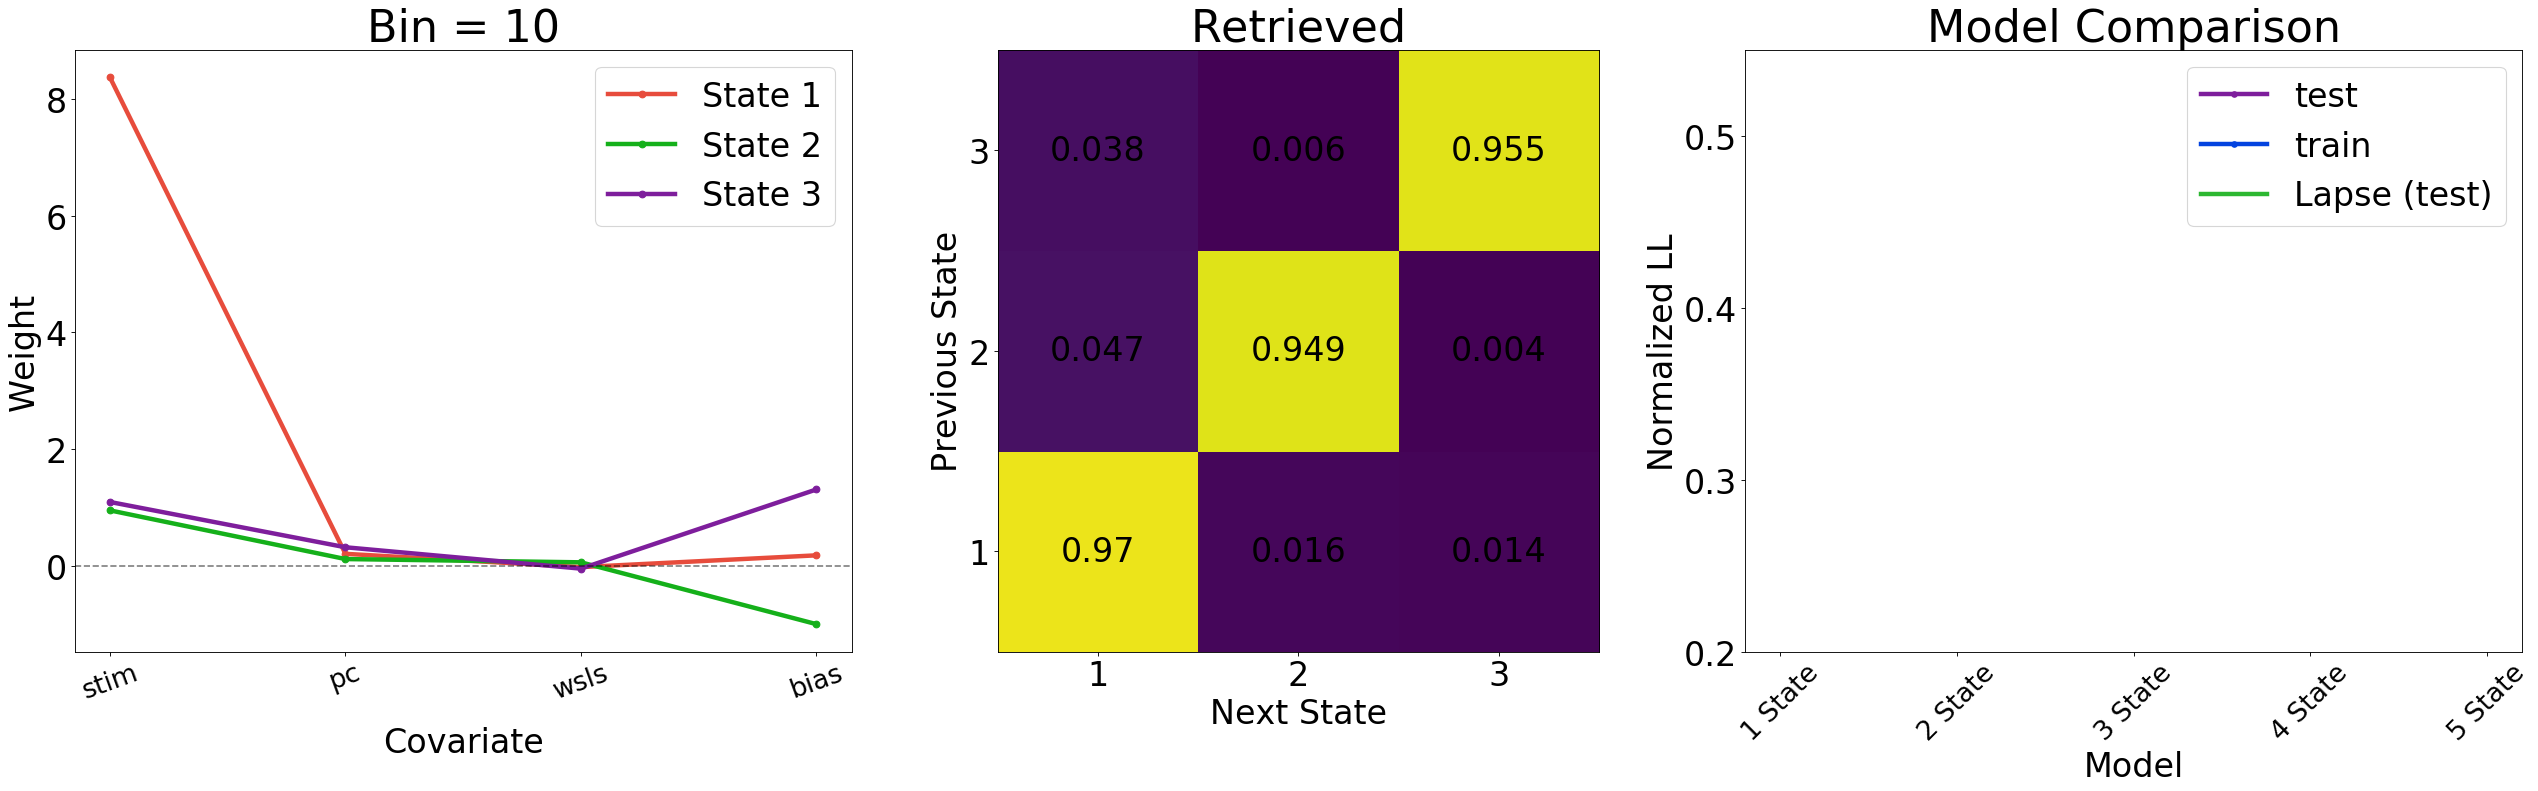

In [24]:

bins_interest = [0, 5, 9]
for b, bin in enumerate(bins_interest):

    labels_for_plot = ['stim', 'pc', 'wsls', 'bias']

    for K in Ks:
        print("K = " + str(K))

        results_dir = '../../results/ibl_global_fit/GLM_HMM_K_' + str(K) + '/bin_' + str(bin+1)  + '/'
        results_dir = '../../results/ibl_global_fit/GLM_HMM' + '/bin_' + str(bin+1) 
        save_directory = processed_ibl_data_path + "best_global_params/GLM_HMM_K_" + str(K) + 'bin_' + str(bin+1)  + '/'
        if not os.path.exists(save_directory):
            os.makedirs(save_directory)

        with open(results_dir + "/best_init_cvbt_dict.json", 'r') as f:
            best_init_cvbt_dict = json.load(f)

        cv_file = results_dir + "cvbt_folds_model.npz"
        cvbt_folds_model = load_cv_arr(cv_file)

        # Get the file name corresponding to the best initialization for
        # given K value
        data_file = '../../results/ibl_global_fit/GLM_HMM_K_' + str(K) + '/bin_' + str(bin+1) 
        raw_file = get_file_name_for_best_model_fold(
            cvbt_folds_model, K, data_file, best_init_cvbt_dict)
        hmm_params, lls = load_glmhmm_data(raw_file)

        # Calculate permutation
        permutation = calculate_state_permutation(hmm_params)
        print(permutation)

        # Save parameters for initializing individual fits
        weight_vectors = hmm_params[2][permutation]
        log_transition_matrix = permute_transition_matrix(
            hmm_params[1][0], permutation)
        init_state_dist = hmm_params[0][0][permutation]
        params_for_individual_initialization = [[init_state_dist],
                                                [log_transition_matrix],
                                                weight_vectors]
        np.savez(
            save_directory + 'best_params_K_' + str(K) + '.npz',
            params_for_individual_initialization)

        # Plot these too:
        cols = ["#e74c3c", "#15b01a", "#7e1e9c", "#3498db", "#f97306"]
        fig = plt.figure(figsize=(4 * 8, 10),
                         dpi=80,
                         facecolor='w',
                         edgecolor='k')
        plt.subplots_adjust(left=0.1,
                            bottom=0.24,
                            right=0.95,
                            top=0.7,
                            wspace=0.8,
                            hspace=0.5)
        plt.subplot(1, 3, 1)
        M = weight_vectors.shape[2] - 1
        for k in range(K):
            plt.plot(range(M + 1),
                     -weight_vectors[k][0],
                     marker='o',
                     label='State ' + str(k + 1),
                     color=cols[k],
                     lw=4)
        plt.xticks(list(range(0, len(labels_for_plot))),
                   labels_for_plot,
                   rotation='20',
                   fontsize=24)
        plt.yticks(fontsize=30)
        plt.legend(fontsize=30)
        plt.axhline(y=0, color="k", alpha=0.5, ls="--")
        # plt.ylim((-3, 14))
        plt.ylabel("Weight", fontsize=30)
        plt.xlabel("Covariate", fontsize=30, labelpad=20)
        plt.title("Bin = " + str(bin+1), fontsize=40)


        plt.subplot(1, 3, 2)
        transition_matrix = np.exp(log_transition_matrix)
        plt.imshow(transition_matrix, vmin=0, vmax=1)
        for i in range(transition_matrix.shape[0]):
            for j in range(transition_matrix.shape[1]):
                text = plt.text(j,
                                i,
                                np.around(transition_matrix[i, j],
                                          decimals=3),
                                ha="center",
                                va="center",
                                color="k",
                                fontsize=30)
        plt.ylabel("Previous State", fontsize=30)
        plt.xlabel("Next State", fontsize=30)
        plt.xlim(-0.5, K - 0.5)
        plt.ylim(-0.5, K - 0.5)
        plt.xticks(range(0, K), ('1', '2', '3', '4', '4', '5', '6', '7',
                                 '8', '9', '10')[:K],
                   fontsize=30)
        plt.yticks(range(0, K), ('1', '2', '3', '4', '4', '5', '6', '7',
                                 '8', '9', '10')[:K],
                   fontsize=30)
        plt.title("Retrieved", fontsize=40)


        plt.subplot(1, 3, 3)
        cols = [
            "#7e1e9c", "#0343df", "#15b01a", "#bf77f6", "#95d0fc",
            "#96f97b"
        ]
        cv_file = results_dir + "cvbt_folds_model.npz"
        data_for_plotting_df, loc_best, best_val, glm_lapse_model = \
            create_cv_frame_for_plotting(
            cv_file)
        cv_file_train = results_dir + "cvbt_train_folds_model.npz"
        train_data_for_plotting_df, train_loc_best, train_best_val, \
        train_glm_lapse_model = create_cv_frame_for_plotting(
            cv_file_train)

        glm_lapse_model_cvbt_means = np.mean(glm_lapse_model, axis=1)
        train_glm_lapse_model_cvbt_means = np.mean(train_glm_lapse_model,
                                                   axis=1)
        g = sns.lineplot(
            data_for_plotting_df['model'],
            data_for_plotting_df['cv_bit_trial'],
            err_style="bars",
            mew=0,
            color=cols[0],
            marker='o',
            ci=68,
            label="test",
            alpha=1,
            lw=4)
        sns.lineplot(
            train_data_for_plotting_df['model'],
            train_data_for_plotting_df['cv_bit_trial'],
            err_style="bars",
            mew=0,
            color=cols[1],
            marker='o',
            ci=68,
            label="train",
            alpha=1,
            lw=4)
        plt.xlabel("Model", fontsize=30)
        plt.ylabel("Normalized LL", fontsize=30)
        plt.xticks([0, 1, 2, 3, 4],
                   ['1 State', '2 State', '3 State', '4 State', '5 State'],
                   rotation=45,
                   fontsize=24)
        plt.yticks(fontsize=15)
        plt.axhline(y=glm_lapse_model_cvbt_means[2],
                    color=cols[2],
                    label="Lapse (test)",
                    alpha=0.9,
                    lw=4)
        plt.legend(loc='upper right', fontsize=30)
        plt.tick_params(axis='y')
        plt.yticks([0.2, 0.3, 0.4, 0.5], fontsize=30)
        plt.ylim((0.2, 0.55))
        plt.title("Model Comparison", fontsize=40)
        fig.tight_layout()

        fig.savefig(results_dir + 'best_params_cross_validation_K_' +
                    str(K) + '.png')